In [2]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset,random_split
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
# from pytorch_lightning import LightningModule
# from pytorch_lightning import Trainer
# import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image


Train
Test
만들기


In [3]:
train='./KWS\calla\data\train'
test='./KWS\calla\data\test'


In [4]:
from torchvision.datasets import ImageFolder


In [5]:
#디바이스 설정
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using{device}device')

# 데이터 전처리
data_transforms=transforms.Compose([transforms.RandomRotation(10),transforms.RandomHorizontalFlip(),transforms.CenterCrop(224),transforms.Resize(224),transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

#데이터셋 로딩
dataset=ImageFolder('data/train',transform=data_transforms)

#데이터셋 분할(train:val=0.8:0.2)
train_size=int(0.8 *len(dataset))
val_size=len(dataset)-train_size
train_data,val_data=random_split(dataset,[train_size,val_size])
test_data = ImageFolder('data/test', transform=data_transforms)

#데이터 로더 생성
train_loader=DataLoader(train_data,batch_size=32,shuffle=True)
val_loader=DataLoader(val_data,batch_size=32,shuffle=False)
test_loader=DataLoader(test_data,batch_size=32,shuffle=False)

#클래스 확인
print(dataset.classes)


usingcpudevice
['bdsr', 'csl', 'fwq', 'gj', 'htj', 'hy', 'lgq', 'lqs', 'lx', 'mf', 'mzd', 'oyx', 'sgt', 'shz', 'smh', 'wxz', 'wzm', 'yyr', 'yzq', 'zmf']


커스텀셋 생성


In [6]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self,data,transform=None):
        self.data=data
        self.transform=transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        path,label=self.path_imgs[idx]
        img=Image.open(path).convert('RGB')
        if self.transform:
            image=self.transform(image)
        return image,label

#모델 정의
class callamodel(nn.Module):
    def __init__(self):
        super(callamodel,self).__init__()
        #모델 아키텍처 정의
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 20)
        self.fc3 = nn.Linear(20, 15)
        self.fc4 = nn.Linear(15, len(dataset.classes))
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)


In [15]:
# 모델 인스턴스 생성
model=callamodel().to(device)

criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.AdamW(model.parameters(),lr=0.001)

#모델 학습
EPOCH=100
for epoch in range(EPOCH):
    train_loss=0.0
    for inputs,labels in train_loader:
        inputs,labels=inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs=model(inputs)
        # print(f'shape가 잘 나오나?? {outputs.shape}')
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    print(f'Epoch {epoch+1},Train Loss:{train_loss/len(train_loader)}')

#모델 평가 
model.eval()
correct=0
total=0
with torch.no_grad():
    for inputs,labels in val_loader:
        # RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor
        inputs,labels=inputs.to(device),labels.to(device)   # 에러 해결하기 위해 이 코드 추가함
        outputs=model(inputs)
        _,predicted=torch.max(outputs.data,1)
        total +=labels.size(0)
        correct+=(predicted==labels).sum().item()
        # 모델 저장
        torch.save(model, 'model.pth')
    print(f'Validation Accuracy:{100* correct/total}%')


Validation Accuracy:90.02677774471883%


In [ ]:


# # 기존 모델 불러오기
# saved_model = torch.load('model.pth')


In [ ]:
# import torch
# from PIL import Image

# # 저장된 모델 불러오기
# model = torch.load('model.pth')
# model.eval()

# # 클래스 이름 확인
# classes = dataset.classes  

# from PIL import Image

# def preprocess_image(image_path):
#     image = Image.open(image_path).convert('RGB')
#     image_tensor = data_transforms(image).unsqueeze(0)
#     return image_tensor

# def classify_image(image_path):
#     image_tensor = preprocess_image(image_path)
    

#     with torch.no_grad():
#         output = model(image_tensor)
#         _, predicted = torch.max(output, 1)
#         predicted_class = classes[predicted.item()]

#     return predicted_class

# # 사용자 입력 받기
# image_path = input("이미지 파일의 전체 경로를 입력하세요: ")
# predicted_class = classify_image(image_path)
# print(f"예측된 클래스: {predicted_class}")


예측된 클래스: shz


In [7]:
dataset.classes


['bdsr',
 'csl',
 'fwq',
 'gj',
 'htj',
 'hy',
 'lgq',
 'lqs',
 'lx',
 'mf',
 'mzd',
 'oyx',
 'sgt',
 'shz',
 'smh',
 'wxz',
 'wzm',
 'yyr',
 'yzq',
 'zmf']

In [28]:


import torch
from PIL import Image

# 저장된 모델 불러오기
model = torch.load('model_re.pth',map_location=device)
model.eval()

# 클래스 인덱스와 이름 매핑 딕셔너리
class_mapping ={0:'팔대산인',
 1:'저수량',
 2:'범문강',
 3:'관준',
 4:'황정견',
 5:'홍일',
 6:'유공권',
 7:'양추생',
 8:'루쉰',
 9:'미불',
 10:'마오쩌둥',
 11:'구양순',
 12:'손과정',
 13:'송휘종',
 14:'사맹해',
 15:'왕희지',
 16:'문징명',
 17:'우우임',
 18:'안진경',
 19:'조맹부'} 

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = data_transforms(image).unsqueeze(0)
    return image_tensor

def classify_image(image_path):
    image_tensor = preprocess_image(image_path)
    
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        predicted_idx = predicted.item()
        predicted_class = class_mapping[predicted_idx]  # 매핑 딕셔너리 사용

    return predicted_class

# 사용자 입력 받기
image_path = input("이미지 파일의 전체 경로를 입력하세요: ")
predicted_class = classify_image(image_path)
print(f"예측된 클래스: {predicted_class}")


예측된 클래스: 마오쩌둥


In [ ]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224]) 0
tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044

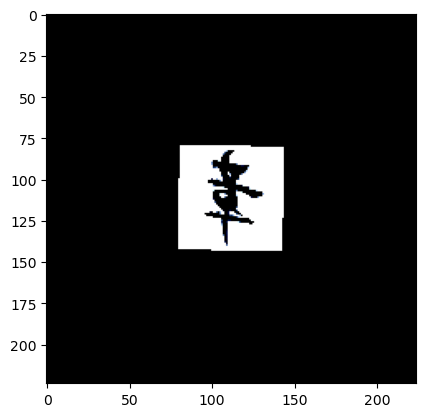

In [ ]:
# Example from class 1
img1, label1 = dataset[0]
print(img1.shape, label1)
print(img1)
show_example(*dataset[0])
